In [1]:
import sys
import os
import time
import numpy as np
import pinocchio as pin

sys.path.append('./python/bsqp')
sys.path.append('./python')
from bsqp.interface import BSQP
from force_estimator import ImprovedForceEstimator

np.set_printoptions(linewidth=99999999)
np.random.seed(42)

class MPC_GATO:
    def __init__(self, model, N=32, dt=0.03125, batch_size=1, constant_f_ext=None):
        self.model = model
        self.model.gravity.linear = np.array([0, 0, -9.81])
        self.data = model.createData()
        
        self.solver = BSQP(
            model_path="indy7-mpc/description/indy7.urdf",
            batch_size=batch_size,
            N=N,
            dt=dt,
            max_sqp_iters=1,
            kkt_tol=0.001,
            max_pcg_iters=200,
            pcg_tol=1e-4,
            solve_ratio=1.0,
            mu=10.0,
            q_cost=2.0,
            qd_cost=1e-2,
            u_cost=2e-6,
            N_cost=50.0,
            q_lim_cost=0.01,
            rho=0.01 
        )
        
        self.q_traj = []  # trajectory for visualization
        
        self.nq = self.model.nq
        self.nv = self.model.nv
        self.nx = self.nq + self.nv
        self.nu = self.model.nv
        self.N = N
        self.dt = dt
        self.batch_size = batch_size
        
        # Store the original world-frame force for reference
        self.constant_f_ext_world = constant_f_ext if constant_f_ext is not None else np.zeros(6)
        
        # Compute the transformed force for GATO (at joint 5 in local frame)
        self.constant_f_ext_gato = None
        if constant_f_ext is not None:
            # We'll compute this after forward kinematics in the simulation
            self.constant_f_ext_gato = np.zeros(6)  # Will be updated
        
        # Initialize improved force estimator with smoother parameters
        if batch_size > 1:
            self.force_estimator = ImprovedForceEstimator(
                batch_size=batch_size,
                initial_radius=5.0,  
                min_radius=0.5,     
                max_radius=10.0,     
                smoothing_factor=0.9 
            )
            self.current_force_batch = None
        else:
            self.force_estimator = None
            self.current_force_batch = None
        
        self.actual_f_ext = pin.StdVec_Force()
        for _ in range(self.model.njoints):
            self.actual_f_ext.append(pin.Force.Zero())
            
        if constant_f_ext is not None:
            self.actual_f_ext[-1] = pin.Force(constant_f_ext[:3], constant_f_ext[3:])

    def transform_force_to_gato_frame(self, q, f_world):
        """
        Transform a force from world frame at end-effector to local frame at joint 5.
        Uses only robot joints (first nq_robot elements of q).
        """
        # Create data for solver model to do kinematics
        data = self.model.createData()
        
        # Use only robot configuration
        q_robot = q[:self.nq]
        
        # Update kinematics on solver model
        pin.forwardKinematics(self.model, data, q_robot)
        pin.updateFramePlacements(self.model, data)
        
        # Joint indices
        jid_5_pin = 6  # Joint 5 in GATO = Joint 6 in Pinocchio
        jid_ee_pin = self.model.njoints - 1  # End-effector
        
        # Get transformations
        transform_world_to_j5 = data.oMi[jid_5_pin]
        transform_world_to_ee = data.oMi[jid_ee_pin]
        
        # Compute transformation from Joint 5 to End-Effector
        transform_j5_to_ee = transform_world_to_j5.inverse() * transform_world_to_ee
        
        # Create force at end-effector in world frame
        force_ee_world = pin.Force(f_world[:3], f_world[3:])
        
        # Transform to Joint 5 local frame
        force_ee_local = transform_world_to_ee.actInv(force_ee_world)
        wrench_j5_local = transform_j5_to_ee.actInv(force_ee_local)
        
        result = np.zeros(6)
        result[:3] = wrench_j5_local.linear
        result[3:] = wrench_j5_local.angular
        
        return result
    
    def update_force_batch(self, q):
        """Generate and set force batch BEFORE solving (called pre-solve)."""
        
        # No external force hypothesis for single batch
        if self.batch_size == 1:  
            return
        
        self.current_force_batch = self.force_estimator.generate_batch()
        # Transform each force hypothesis to GATO frame
        transformed_batch = np.zeros_like(self.current_force_batch)
        for i in range(self.batch_size):
            # Each hypothesis is in world frame, transform to GATO frame
            transformed_batch[i, :] = self.transform_force_to_gato_frame(q, self.current_force_batch[i, :])
        
        self.solver.set_f_ext_B(transformed_batch)
    
    def evaluate_best_trajectory(self, x_last, u_last, x_curr, dt):
        """Evaluate which trajectory best matches reality (called post-solve)."""
        if self.batch_size == 1:
            return 0
        
        # Simulate all hypotheses with their corresponding forces
        x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
        
        # Calculate errors for all hypotheses
        errors = np.linalg.norm(x_next_batch - x_curr[None, :], axis=1)
        best_id = np.argmin(errors)
        
        # Update estimator with results
        self.force_estimator.update(best_id, errors, alpha=0.4, beta=0.5)
        
        return best_id
                
    def run_mpc_fig8(self, x_start, fig8_traj, sim_dt=0.001, sim_time=5):        
            
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'ee_goal': [],
            'ee_actual': [],  # Actual end-effector positions
            'ee_velocity': [],  # End-effector velocities
            'controls': [],  # Control inputs (torques)
            'joint_positions': [],  # All joint positions
            'joint_velocities': [],  # All joint velocities
            'timestamps': [],  # Time stamps for each step
            'sqp_iters': [],  # SQP iterations
            'pcg_iters': [],  # PCG iterations
            'force_estimates': [],  # Force estimates (if batch)
            'force_estimates_gato': [],  # Force estimates in GATO frame
            'force_radius': [],  # Force estimator search radius
            'force_confidence': [],  # Force estimator confidence
            'best_trajectory_id': []  # Which trajectory was selected
        }
        
        total_sim_time = 0.0
        steps = 0
        accumulated_time = 0.0
        
        x_curr, q, dq = x_start, x_start[:self.nq], x_start[self.nq:self.nx]
        x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
        ee_g = fig8_traj[:6*self.N]
        ee_g_batch = np.tile(ee_g, (self.batch_size, 1))
        XU = np.zeros(self.N*(self.nx+self.nu)-self.nu)
        for i in range(self.N):
            start_idx = i * (self.nx + self.nu)
            XU[start_idx:start_idx+self.nx] = x_curr
        self.solver.reset_dual()
        XU_batch = np.tile(XU, (self.batch_size, 1))
        
        # Warm up run with initial force batch
        self.update_force_batch(q)
        solve_start = time.time()
        XU_batch, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
        solve_time = time.time() - solve_start
        XU_best = XU_batch[0, :]
        
        print(f"\n========== Running MPC for {sim_time} seconds with N={self.N} and batch size={self.batch_size} ==========")
        if self.constant_f_ext_world is not None:
            print(f"External force at EE (world frame): {self.constant_f_ext_world[:3]}")
                
        while total_sim_time < sim_time:
            steps += 1
            
            timestep = solve_time
            
            x_last = x_curr
            u_last = XU_best[self.nx:self.nx+self.nu]
            
            # ----- Step Simulation -----
            
            nsteps = int(timestep/sim_dt)
            for i in range(nsteps):
                offset = int(i/(self.dt/sim_dt))  # get correct control input
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                q, dq = self.rk4(q, dq, u, sim_dt)
                total_sim_time += sim_dt
                self.q_traj.append(q)
                
            if timestep%sim_dt > 1e-5: # 
                accumulated_time += timestep%sim_dt
                
            if accumulated_time - sim_dt > 0.0:
                accumulated_time = 0.0
                
                offset = int(nsteps/(self.dt/sim_dt))
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                q, dq = self.rk4(q, dq, u, sim_dt)
                total_sim_time += sim_dt
                self.q_traj.append(q)
                
            x_curr = np.concatenate([q, dq])
            
            # ----- Optimize trajectory -----
            
            # shift eepos goal
            eepos_offset = int(total_sim_time / self.dt)
            if eepos_offset >= len(fig8_traj)/6 - 6*self.N: 
                print("End of trajectory")
                break
            
            x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
            ee_g = self.get_ee_g_traj(fig8_traj, eepos_offset)
            ee_g_batch[:, :] = ee_g
            XU_batch[:, :self.nx] = x_curr
            
            self.update_force_batch(q)
            
            solve_start = time.time()
            XU_batch_new, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
            solve_time = time.time() - solve_start
            
            best_id = self.evaluate_best_trajectory(x_last, u_last, x_curr, sim_dt)

            XU_best = XU_batch_new[best_id, :]
            XU_batch[:, :] = XU_best
            # -----
            
            ee_pos = self.eepos(q)
            pin.forwardKinematics(self.model, self.data, q, dq)
            ee_vel = pin.getFrameVelocity(self.model, self.data, 6, pin.LOCAL_WORLD_ALIGNED).linear
            
            stats['timestamps'].append(total_sim_time)
            # Store GPU time for statistics (in ms)
            stats['solve_times'].append(float(round(gpu_solve_time/1e3, 5)))
            goaldist = np.sqrt(np.sum((ee_pos[:3] - ee_g[6:9])**2))
            stats['goal_distances'].append(float(round(goaldist, 5)))
            stats['ee_goal'].append(ee_g[6:9].copy())
            stats['ee_actual'].append(ee_pos.copy())
            stats['ee_velocity'].append(ee_vel.copy())
            stats['controls'].append(u_last.copy())
            stats['joint_positions'].append(q.copy())
            stats['joint_velocities'].append(dq.copy())
            stats['best_trajectory_id'].append(best_id)
            
            # Get solver statistics
            solver_stats = self.solver.get_stats()
            stats['sqp_iters'].append(solver_stats['sqp_iters'])
            stats['pcg_iters'].append(solver_stats['pcg_iters'][0] if len(solver_stats['pcg_iters']) > 0 else 0)
            
            # Force estimator statistics (if batch)
            if self.force_estimator:
                est_stats = self.force_estimator.get_stats()
                stats['force_estimates'].append(est_stats['smoothed_estimate'].copy())
                # Also store the GATO-frame equivalent
                gato_force = self.transform_force_to_gato_frame(q, est_stats['smoothed_estimate'])
                stats['force_estimates_gato'].append(gato_force.copy())
                stats['force_radius'].append(est_stats['radius'])
                stats['force_confidence'].append(est_stats['confidence'])
            else:
                stats['force_estimates'].append(self.constant_f_ext_world.copy() if self.constant_f_ext_world is not None else np.zeros(6))
                stats['force_estimates_gato'].append(self.constant_f_ext_gato.copy() if self.constant_f_ext_gato is not None else np.zeros(6))
                stats['force_radius'].append(0.0)
                stats['force_confidence'].append(1.0)
            
        #     if steps % 512 == 0:
        #         # Also print force estimate for monitoring
        #         if self.force_estimator:
        #             est_stats = self.force_estimator.get_stats()
        #             smoothed = est_stats['smoothed_estimate']
        #             gato_force = stats['force_estimates_gato'][-1]
        #             print(f"err=\033[91m{goaldist:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | id={best_id} | f_world=[{smoothed[0]:5.1f}, {smoothed[1]:5.1f}, {smoothed[2]:5.1f}] | f_gato=[{gato_force[0]:5.1f}, {gato_force[1]:5.1f}, {gato_force[2]:5.1f}] | t={total_sim_time:4.3f}s")
        #         else:
        #             print(f"err=\033[91m{goaldist:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | id={best_id} | t={total_sim_time:4.3f}s")

        print(f"avg err: {np.mean(stats['goal_distances']):4.3f}")
        print(f"avg t_sqp: {np.mean(stats['solve_times']):4.3f}ms")
        print(f"========== MPC finished ==========")
        
        # Convert lists to numpy arrays for easier processing
        for key in stats:
            if stats[key]:
                stats[key] = np.array(stats[key])

        return self.q_traj, stats
    
    def get_ee_g_traj(self, traj, offset):
        if offset >= len(traj)/6 - 6*self.N:
            print("=> end of trajectory, wrapping around")
            offset %= len(traj)/6
        return traj[6*offset:6*(offset+self.N)]
    
    def rk4(self, q, dq, u, dt):
        k1q = dq
        k1v = pin.aba(self.model, self.data, q, dq, u, self.actual_f_ext)
        q2 = pin.integrate(self.model, q, k1q * dt / 2)
        k2q = dq + k1v * dt/2
        k2v = pin.aba(self.model, self.data, q2, k2q, u, self.actual_f_ext)
        q3 = pin.integrate(self.model, q, k2q * dt / 2)
        k3q = dq + k2v * dt/2
        k3v = pin.aba(self.model, self.data, q3, k3q, u, self.actual_f_ext)
        q4 = pin.integrate(self.model, q, k3q * dt)
        k4q = dq + k3v * dt
        k4v = pin.aba(self.model, self.data, q4, k4q, u, self.actual_f_ext)
        dq_next = dq + (dt/6) * (k1v + 2*k2v + 2*k3v + k4v)
        avg_dq = (k1q + 2*k2q + 2*k3q + k4q) / 6
        q_next = pin.integrate(self.model, q, avg_dq * dt)
        return q_next, dq_next
            
    def eepos(self, q):
        pin.forwardKinematics(self.model, self.data, q)
        return self.data.oMi[6].translation


def figure8(dt, A_x=0.4, A_z=0.4, offset=[0.0, 0.5, 0.6], period=8, cycles=6, theta=np.pi/4):  # angle to rotate the figure 8 around z-axis
    x_unrot = lambda t: offset[0] + A_x * np.sin(t)  # X goes from -xamplitude to xamplitude
    y_unrot = lambda t: offset[1]
    z_unrot = lambda t: offset[2] + A_z * np.sin(2*t)/2 + A_z/2  # Z goes from -zamplitude/2 to zamplitude/2
    
    R = np.array([[np.cos(theta), -np.sin(theta), 0.0],
                  [np.sin(theta), np.cos(theta), 0.0],
                  [0.0, 0.0, 1.0]])
    
    def get_rotated_coords(t):
        unrot = np.array([x_unrot(t), y_unrot(t), z_unrot(t)])
        rot = R @ unrot
        return rot[0], rot[1], rot[2]
    
    x = lambda t: get_rotated_coords(t)[0]
    y = lambda t: get_rotated_coords(t)[1] 
    z = lambda t: get_rotated_coords(t)[2]
    timesteps = np.linspace(0, 2*np.pi, int(period/dt))
    fig_8 = np.array([[x(t), y(t), z(t), 0.0, 0.0, 0.0] for t in timesteps]).reshape(-1)
    return np.tile(fig_8, int(cycles))

In [2]:
# Load URDF model

urdf_path = "indy7-mpc/description/indy7.urdf"
model_dir = "indy7-mpc/description/"

model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

N = 32
dt = 0.01

f_ext = np.array([0.0, 0.0, -60.0, 0.0, 0.0, 0.0])

xstart = np.hstack((np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), np.zeros(6)))
# xstart = np.hstack((np.array([-1.096711, -0.09903229,  0.83125766, -0.10907673,  0.49704404,  0.01499449]), np.zeros(6)))

fig_8_traj = figure8(dt)

mpc = MPC_GATO(model, N=N, dt=dt, batch_size=1, constant_f_ext=f_ext)
q_trajectory, mpc_stats = mpc.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.001, sim_time=16.0)
mpc_4 = MPC_GATO(model, N=N, dt=dt, batch_size=4, constant_f_ext=f_ext)
q_trajectory_4, mpc_stats_4 = mpc_4.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.001, sim_time=16.0)
mpc_8 = MPC_GATO(model, N=N, dt=dt, batch_size=8, constant_f_ext=f_ext)
q_trajectory_8, mpc_stats_8 = mpc_8.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.001, sim_time=16.0)
mpc_16 = MPC_GATO(model, N=N, dt=dt, batch_size=16, constant_f_ext=f_ext)
q_trajectory_16, mpc_stats_16 = mpc_16.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.001, sim_time=16.0)
mpc_32 = MPC_GATO(model, N=N, dt=dt, batch_size=32, constant_f_ext=f_ext)
q_trajectory_32, mpc_stats_32 = mpc_32.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.001, sim_time=16.0)
mpc_64 = MPC_GATO(model, N=N, dt=dt, batch_size=64, constant_f_ext=f_ext)
q_trajectory_64, mpc_stats_64 = mpc_64.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.001, sim_time=16.0)
mpc_128 = MPC_GATO(model, N=N, dt=dt, batch_size=128, constant_f_ext=f_ext)
q_trajectory_128, mpc_stats_128 = mpc_128.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.001, sim_time=16.0)

T : f

========== Running MPC for 16.0 seconds with N=32 and batch size=1 ==========
External force at EE (world frame): [  0.   0. -60.]
avg err: 0.082
avg t_sqp: 0.114ms
========== MPC finished ==========

========== Running MPC for 16.0 seconds with N=32 and batch size=4 ==========
External force at EE (world frame): [  0.   0. -60.]
T : f
avg err: 0.058
avg t_sqp: 0.244ms
========== MPC finished ==========

========== Running MPC for 16.0 seconds with N=32 and batch size=8 ==========
External force at EE (world frame): [  0.   0. -60.]
T : f
avg err: 0.054
avg t_sqp: 0.318ms
========== MPC finished ==========

========== Running MPC for 16.0 seconds with N=32 and batch size=16 ==========
External force at EE (world frame): [  0.   0. -60.]
T : f
avg err: 0.049
avg t_sqp: 0.346ms
========== MPC finished ==========
T : f

========== Running MPC for 16.0 seconds with N=32 and batch size=32 ==========
External force at EE (world frame): [  0.   0. -60.]
avg err: 0.049
avg t_sqp: 0.466m

In [5]:
import meshcat.geometry as g
import meshcat.transformations as tf
from pinocchio.visualize import MeshcatVisualizer
import numpy as np

# load two robot models
model1, visual_model1, collision_model1 = pin.buildModelsFromUrdf(urdf_path, model_dir)
model2, visual_model2, collision_model2 = pin.buildModelsFromUrdf(urdf_path, model_dir)

# single visualizer
viz = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot1", color=[1.0, 0.0, 0.0, 0.4])
viz_2 = MeshcatVisualizer(model2, collision_model2, visual_model2)
viz_2.initViewer(viz.viewer)
viz_2.loadViewerModel(rootNodeName="robot2", color=[0.0, 1.0, 0.0, 0.7])

# Draw figure 8 trajectory points
for i in range(int(len(fig_8_traj)/30)):  # number of points in one cycle
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.015), 
        g.MeshLambertMaterial(color=0xff0000))
    T = tf.translation_matrix(np.array(fig_8_traj[6*i:6*(i+1)][:3]))
    viz.viewer[f'point{i}'].set_transform(T)    

# Create arrow to visualize force
f_ext = np.array([0.0, 0.0, -60.0])
force_magnitude = np.linalg.norm(f_ext[:3])
force_direction = f_ext[:3] / force_magnitude
arrow_length = force_magnitude / 100.0  # Scale down the force for visualization

# Create arrow geometry
arrow = g.Cylinder(height=arrow_length, radius=0.005)
arrow_2 = g.Cylinder(height=arrow_length, radius=0.005)
viz.viewer['force_arrow'].set_object(arrow, g.MeshLambertMaterial(color=0xffff00))
viz_2.viewer['force_arrow_2'].set_object(arrow_2, g.MeshLambertMaterial(color=0xffff00))
    
q_trajectory1, q_trajectory2 = q_trajectory, q_trajectory_32
num_points = int(len(fig_8_traj)/30) 

t = 0
if not q_trajectory1 or not q_trajectory2:
    raise ValueError("Trajectories not loaded correctly")

ratio = len(q_trajectory1) / len(q_trajectory2)
data1 = model1.createData()
data2 = model2.createData()
while True:
    # Calculate indices safely
    idx1 = int(t * ratio) % len(q_trajectory1)
    idx2 = t % len(q_trajectory2)

    # Display robot configurations
    viz.display(q_trajectory1[idx1])
    viz_2.display(q_trajectory2[idx2])

    # --- Update force arrow position and orientation ---
    pin.forwardKinematics(model1, data1, q_trajectory1[idx1])
    pin.updateFramePlacements(model1, data1)
    ee_position = data1.oMi[6].translation
    
    pin.forwardKinematics(model2, data2, q_trajectory2[idx2])
    pin.updateFramePlacements(model2, data2)
    ee_position_2 = data2.oMi[6].translation

    # --- Calculate Rotation ---
    default_axis = np.array([0., 1., 0.])  # Meshcat cylinder's axis
    dot_product = np.dot(default_axis, force_direction)
    dot_product = np.clip(dot_product, -1.0, 1.0)

    rot_angle = np.arccos(dot_product)
    if np.abs(rot_angle) > 0.001:  # Only rotate if needed
        rot_axis = np.cross(default_axis, force_direction)
        if np.linalg.norm(rot_axis) > 0.001:  # Check for non-zero axis
            rot_axis /= np.linalg.norm(rot_axis)  # Normalize rotation axis
            R = tf.rotation_matrix(rot_angle, rot_axis)
        else:
            R = np.eye(4)  # No rotation needed
    else:
        R = np.eye(4)  # No rotation needed

    T = tf.translation_matrix(ee_position - (arrow_length/2) * force_direction)
    T_2 = tf.translation_matrix(ee_position_2 - (arrow_length/2) * force_direction)
    viz.viewer['force_arrow'].set_transform(T @ R)
    viz_2.viewer['force_arrow_2'].set_transform(T_2 @ R)
    
    t += 1
    time.sleep(0.001)  # display rate

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


/home/alex/a2r/new_gato/GATO/.venv/lib/python3.10/site-packages/cmeel.prefix/lib/python3.10/site-packages/pinocchio/visualize/meshcat_visualizer.py:914: DeprecatedWarning: The 'color' argument is deprecated and will be removed in a future version of Pinocchio. Consider using 'collision_color' and 'visual_color' instead.
  warnings.warn(


NameError: name 'q_trajectory' is not defined

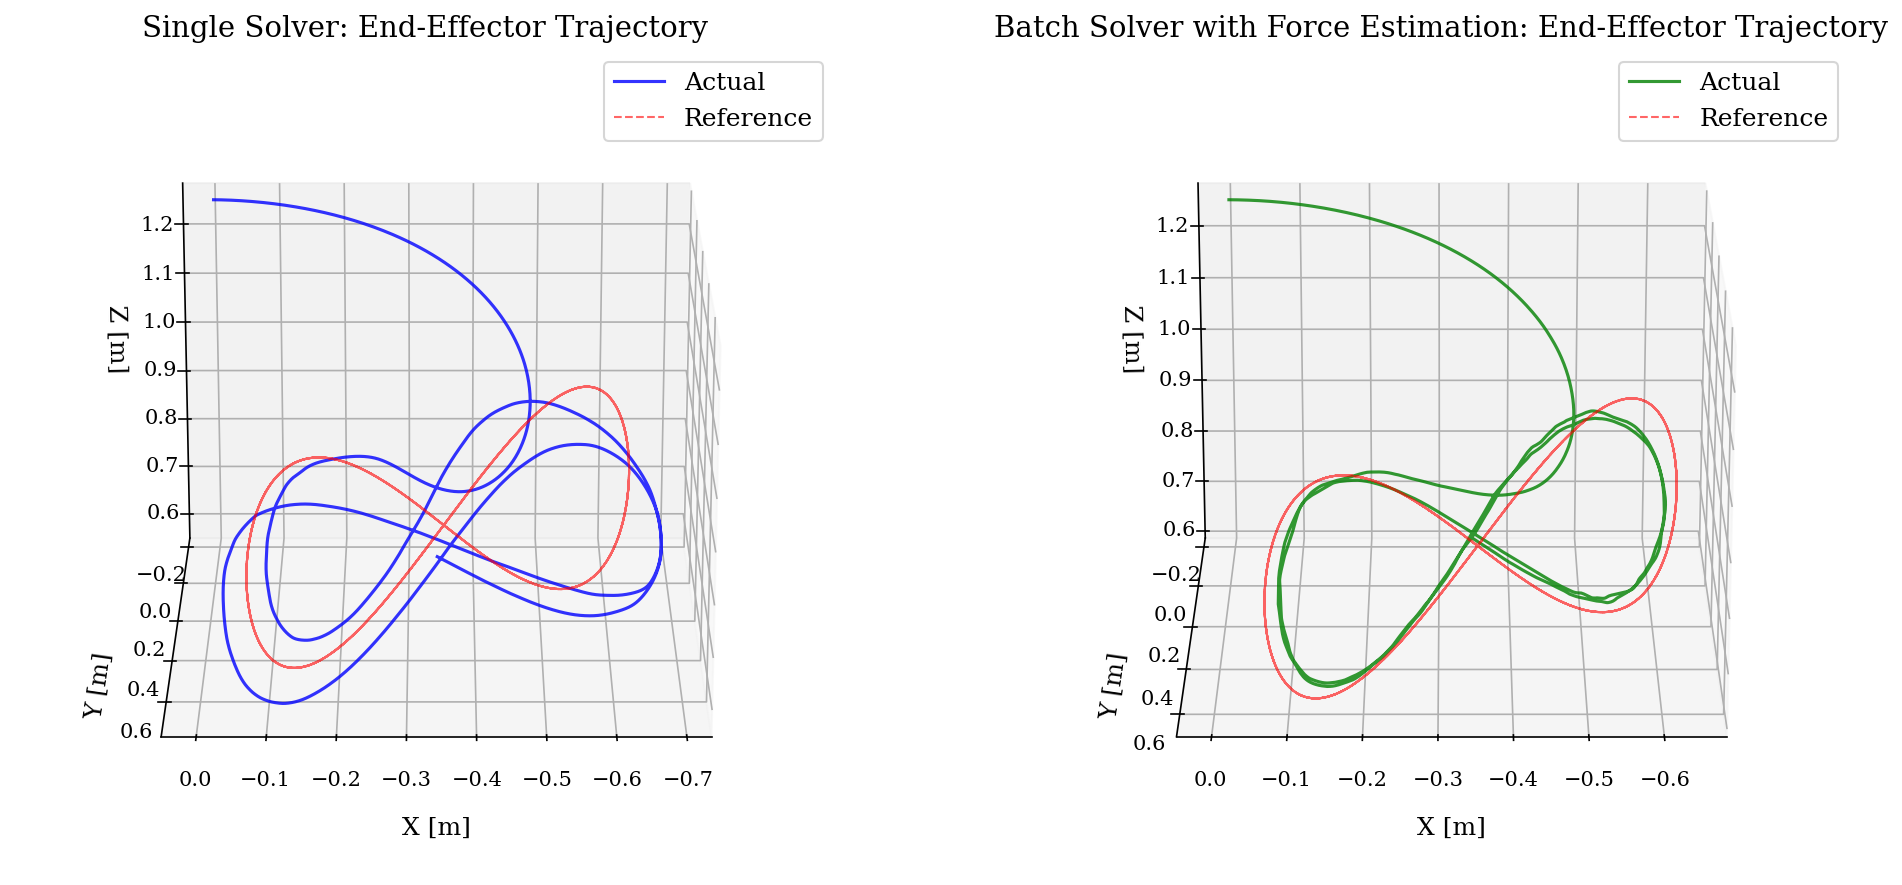

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Set publication quality defaults
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 300

# Extract reference trajectory points
ref_traj = fig_8_traj.reshape(-1, 6)[:, :3]

# Create figure for 3D trajectory
fig = plt.figure(figsize=(14, 6))

# Single solver 3D plot
ax1 = fig.add_subplot(121, projection='3d')
if 'ee_actual' in mpc_stats and len(mpc_stats['ee_actual']) > 0:
    ee_actual = mpc_stats['ee_actual']
    ax1.plot(ee_actual[:, 0], ee_actual[:, 1], ee_actual[:, 2], 
             'b-', linewidth=1.5, label='Actual', alpha=0.8)
ax1.plot(ref_traj[:, 0], ref_traj[:, 1], ref_traj[:, 2], 
         'r--', linewidth=1.0, label='Reference', alpha=0.6)
ax1.set_xlabel('X [m]', labelpad=10)
ax1.set_ylabel('Y [m]', labelpad=10)
ax1.set_zlabel('Z [m]', labelpad=10)
ax1.set_title('Single Solver: End-Effector Trajectory')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.view_init(elev=20, azim=90)

# Batch solver 3D plot
ax2 = fig.add_subplot(122, projection='3d')
if 'ee_actual' in mpc_stats_32 and len(mpc_stats_32['ee_actual']) > 0:
    ee_actual_batch = mpc_stats_32['ee_actual']
    ax2.plot(ee_actual_batch[:, 0], ee_actual_batch[:, 1], ee_actual_batch[:, 2], 
             'g-', linewidth=1.5, label='Actual', alpha=0.8)
ax2.plot(ref_traj[:, 0], ref_traj[:, 1], ref_traj[:, 2], 
         'r--', linewidth=1.0, label='Reference', alpha=0.6)
ax2.set_xlabel('X [m]', labelpad=10)
ax2.set_ylabel('Y [m]', labelpad=10)
ax2.set_zlabel('Z [m]', labelpad=10)
ax2.set_title('Batch Solver with Force Estimation: End-Effector Trajectory')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.view_init(elev=20, azim=90)

plt.tight_layout()
plt.savefig('3d_trajectory_comparison.pdf', bbox_inches='tight')
plt.show()

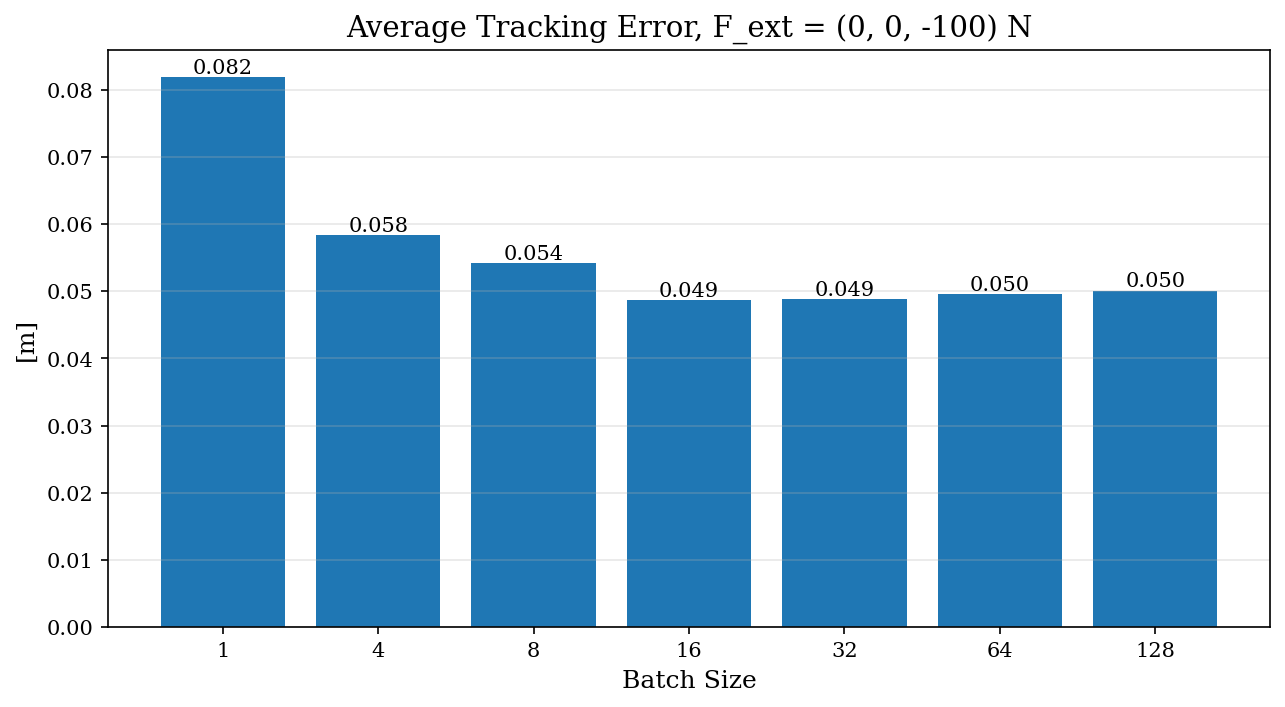

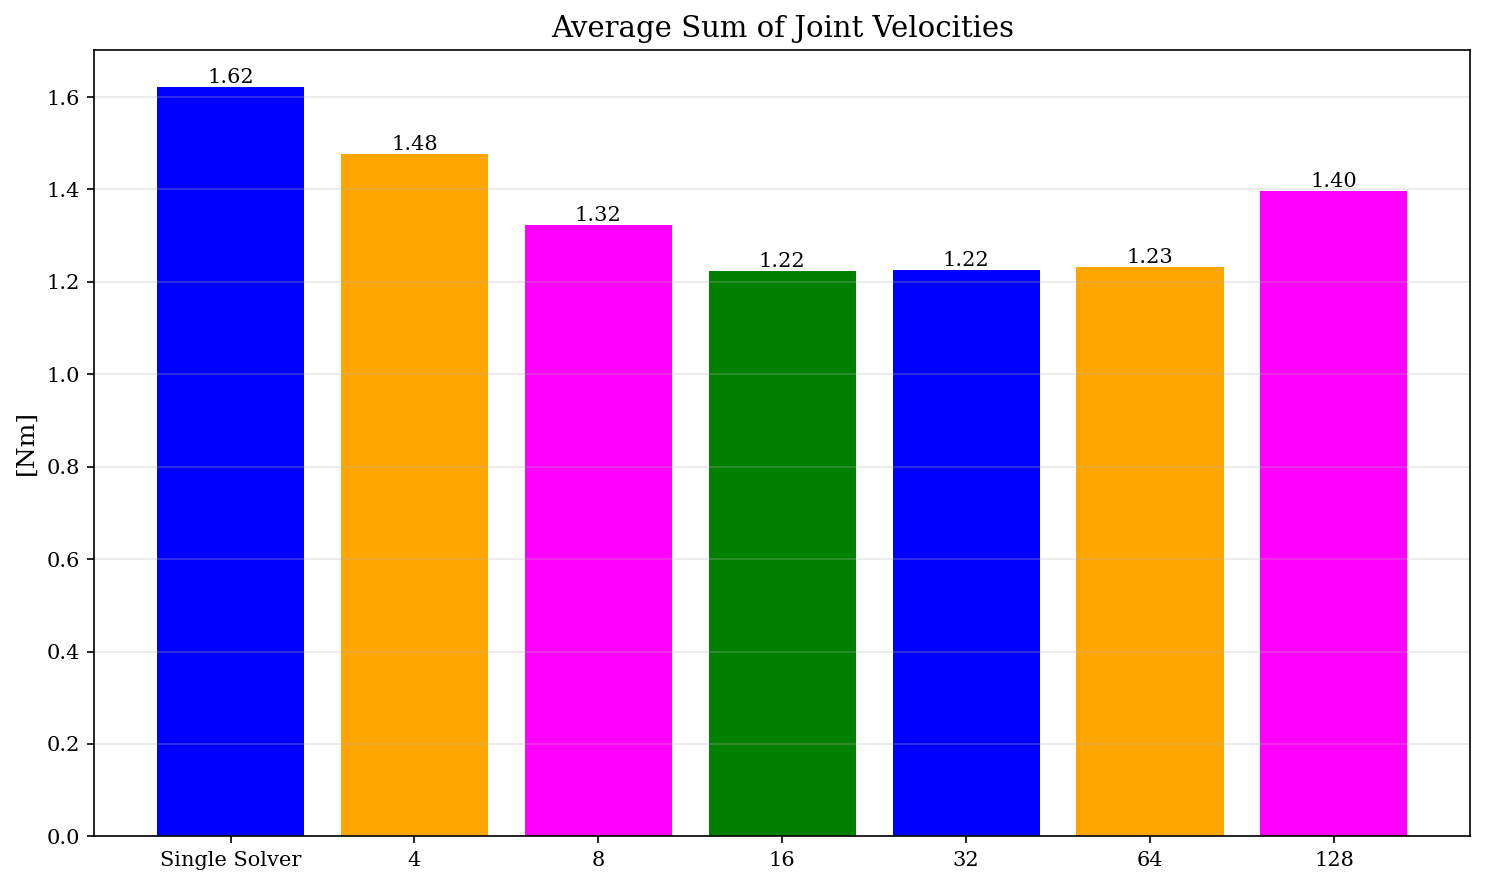

<Figure size 960x720 with 0 Axes>

In [8]:
# Tracking Error and Solver Performance Analysis
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# 1. Total Tracking Error Bar Plot
ax = axes
solvers = []
total_errors = []

solvers.append('1')
total_errors.append(np.sum(mpc_stats['goal_distances'])/len(mpc_stats['goal_distances']))

solvers.append('4')
total_errors.append(np.sum(mpc_stats_4['goal_distances'])/len(mpc_stats_4['goal_distances']))

solvers.append('8')
total_errors.append(np.sum(mpc_stats_8['goal_distances'])/len(mpc_stats_8['goal_distances']))

solvers.append('16')
total_errors.append(np.sum(mpc_stats_16['goal_distances'])/len(mpc_stats_16['goal_distances']))

solvers.append('32')
total_errors.append(np.sum(mpc_stats_32['goal_distances'])/len(mpc_stats_32['goal_distances']))

solvers.append('64')
total_errors.append(np.sum(mpc_stats_64['goal_distances'])/len(mpc_stats_64['goal_distances']))

solvers.append('128')
total_errors.append(np.sum(mpc_stats_128['goal_distances'])/len(mpc_stats_128['goal_distances']))

if solvers and total_errors:
    bars = ax.bar(solvers, total_errors)
    ax.set_xlabel('Batch Size')
    ax.set_ylabel('[m]')
    ax.set_title('Average Tracking Error, F_ext = (0, 0, -100) N')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, error in zip(bars, total_errors):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{error:.3f}', ha='center', va='bottom')

import pandas as pd
import matplotlib.pyplot as plt
control_data = {}

sum_torque = np.sum(np.abs(mpc_stats['joint_velocities']), axis=1)
control_data['Single Solver'] = np.mean(sum_torque)

sum_torque_4 = np.sum(np.abs(mpc_stats_4['joint_velocities']), axis=1)
control_data['4'] = np.mean(sum_torque_4)

sum_torque_8 = np.sum(np.abs(mpc_stats_8['joint_velocities']), axis=1)
control_data['8'] = np.mean(sum_torque_8)

sum_torque_16 = np.sum(np.abs(mpc_stats_16['joint_velocities']), axis=1)
control_data['16'] = np.mean(sum_torque_16)

sum_torque_32 = np.sum(np.abs(mpc_stats_32['joint_velocities']), axis=1)
control_data['32'] = np.mean(sum_torque_32)

sum_torque_64 = np.sum(np.abs(mpc_stats_64['joint_velocities']), axis=1)
control_data['64'] = np.mean(sum_torque_64)

sum_torque_128 = np.sum(np.abs(mpc_stats_128['joint_velocities']), axis=1)
control_data['128'] = np.mean(sum_torque_128)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
solvers = list(control_data.keys())
values = list(control_data.values())
bars = ax.bar(solvers, values, color=['blue', 'orange', 'magenta', 'green'])
ax.set_ylabel('[Nm]')
ax.set_title('Average Sum of Joint Velocities')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

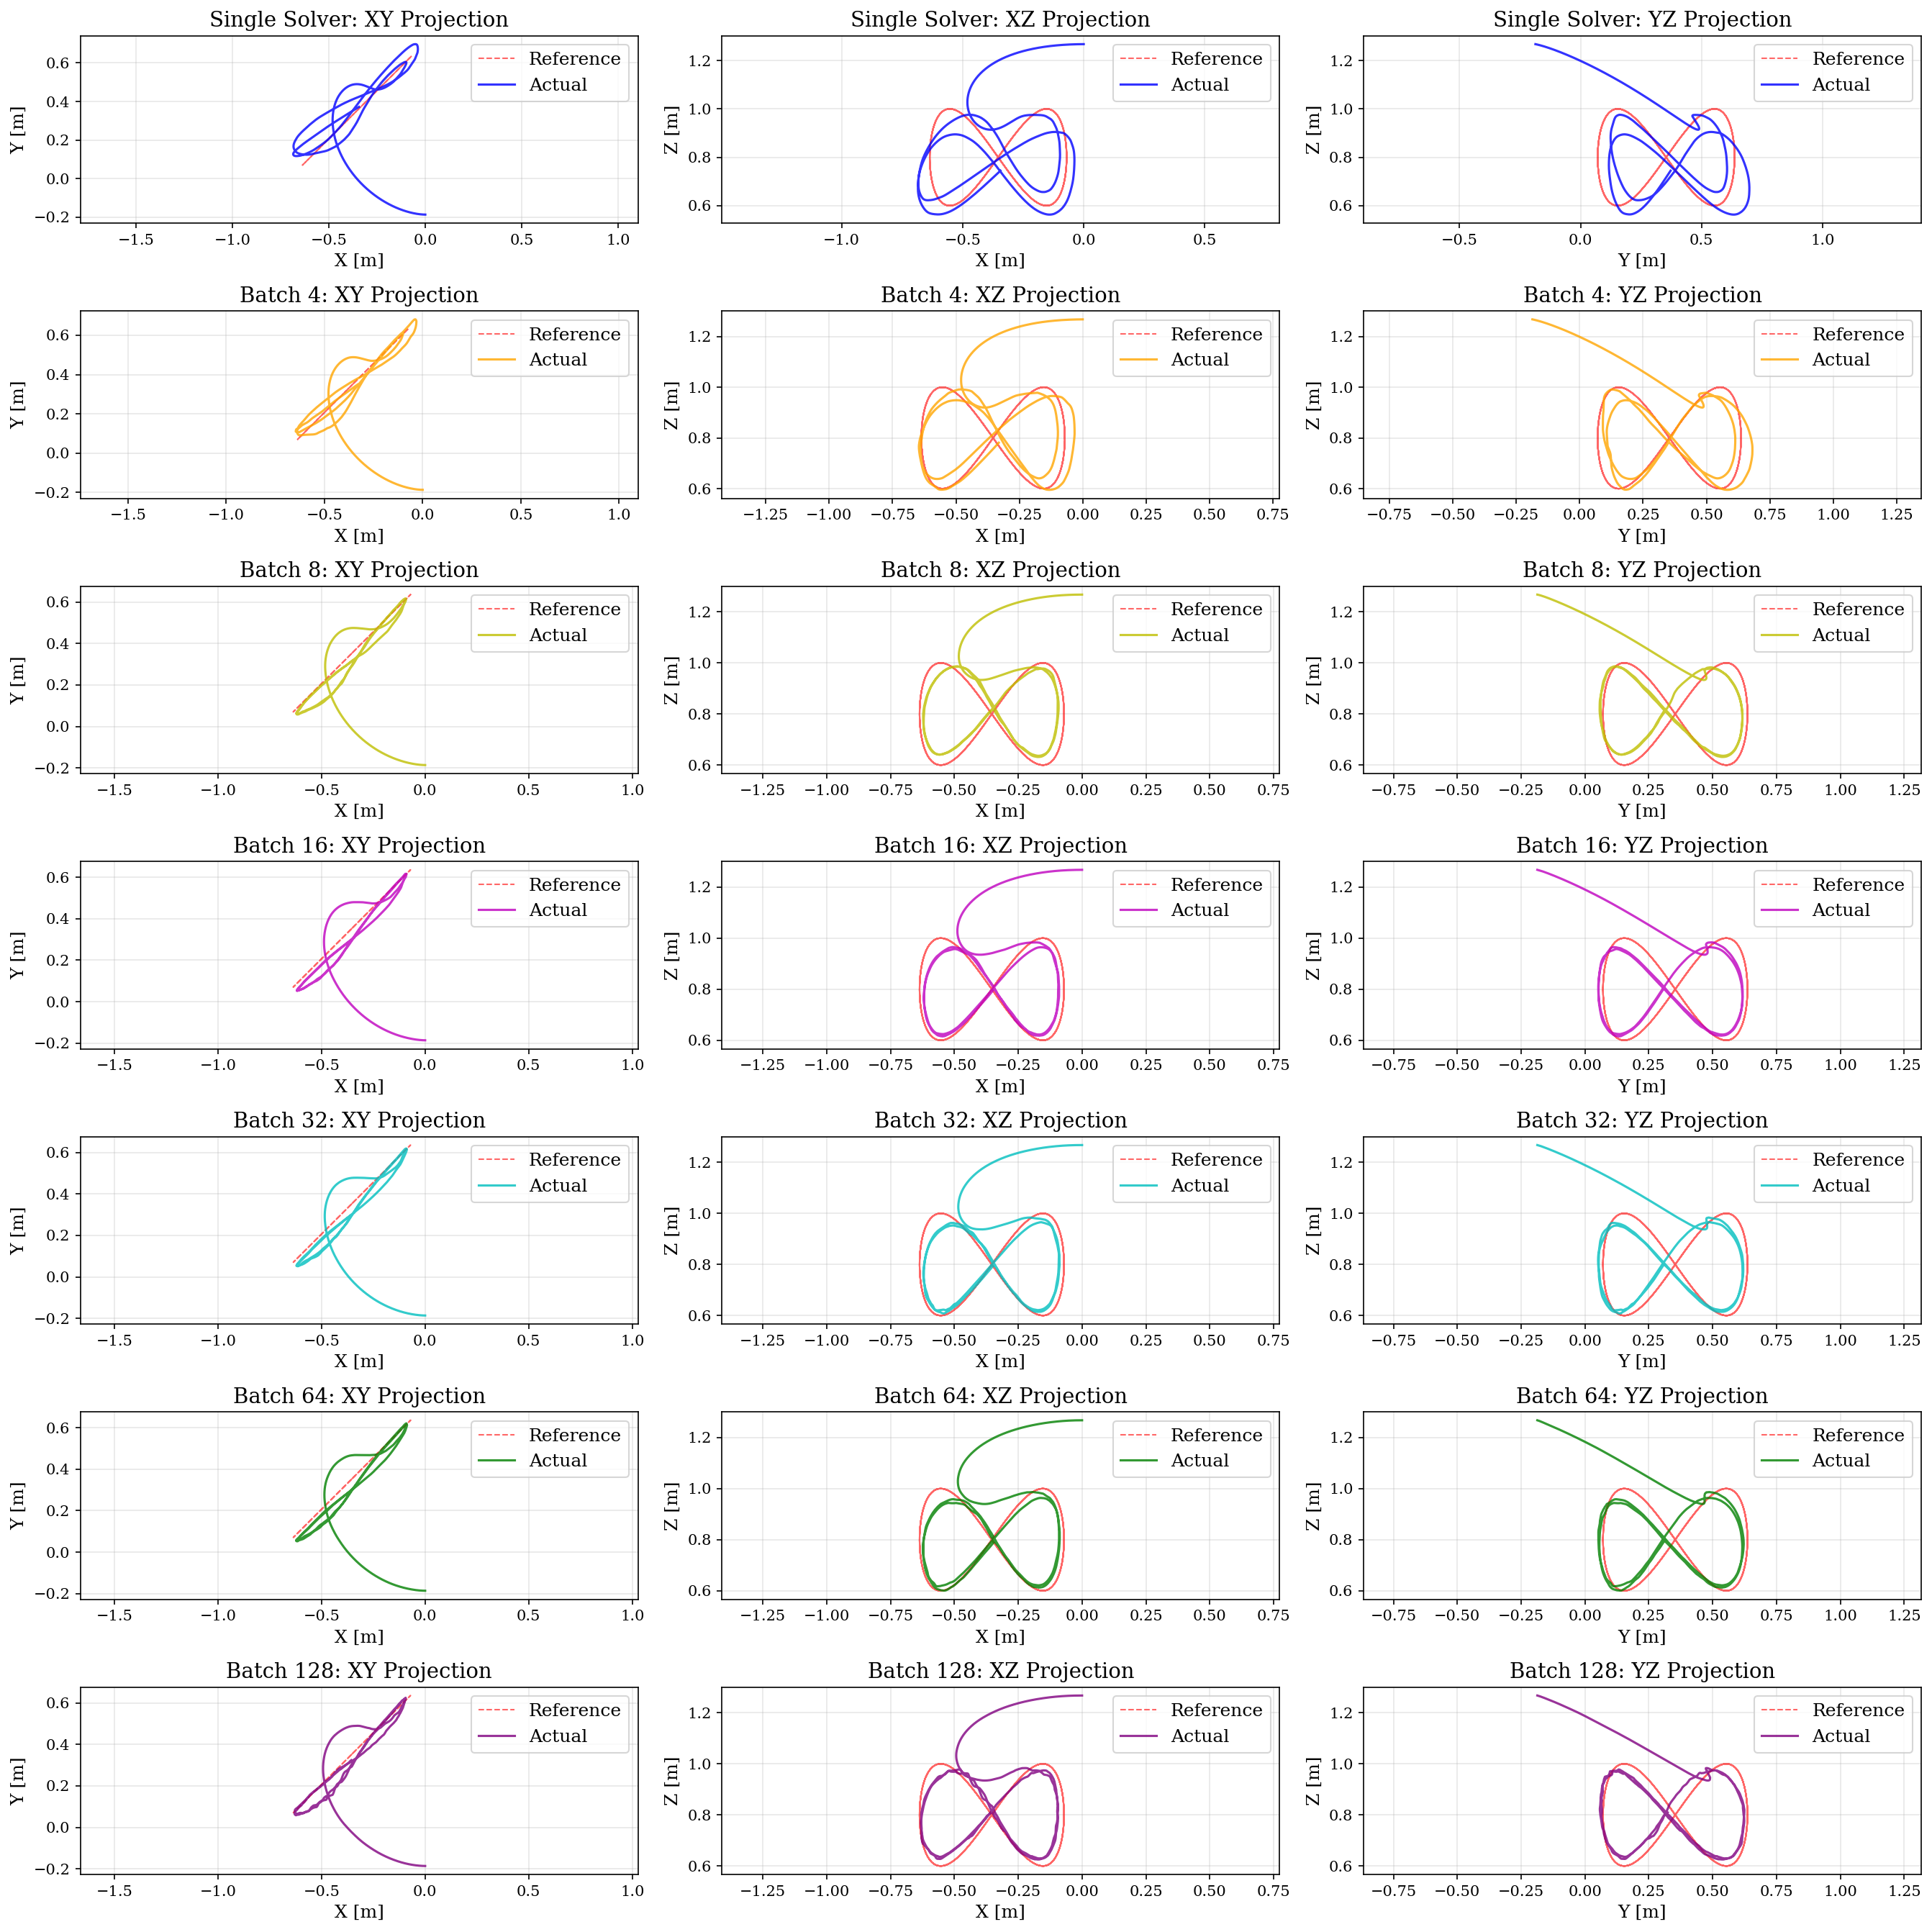

In [9]:
fig, axes = plt.subplots(7, 3, figsize=(18, 18))

# Reference trajectory
ref_traj = fig_8_traj.reshape(-1, 6)[:, :3]

# Define all batch sizes and stats to plot
batch_configs = [
    ('Single Solver', mpc_stats, 'b-'),
    ('Batch 4', mpc_stats_4, 'orange'),
    ('Batch 8', mpc_stats_8, 'y-'),
    ('Batch 16', mpc_stats_16, 'm-'),
    ('Batch 32', mpc_stats_32, 'c-'),
    ('Batch 64', mpc_stats_64, 'g-'),
    ('Batch 128', mpc_stats_128, 'purple')
]

# Plot projections for each configuration
for row, (label, stats, color) in enumerate(batch_configs):
    if 'ee_actual' in stats and len(stats['ee_actual']) > 0:
        ee_actual = stats['ee_actual']
        
        # XY Projection
        ax = axes[row, 0]
        ax.plot(ref_traj[:, 0], ref_traj[:, 1], 'r--', linewidth=1.0, label='Reference', alpha=0.6)
        ax.plot(ee_actual[:, 0], ee_actual[:, 1], color, linewidth=1.5, label='Actual', alpha=0.8)
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_title(f'{label}: XY Projection')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axis('equal')
        
        # XZ Projection
        ax = axes[row, 1]
        ax.plot(ref_traj[:, 0], ref_traj[:, 2], 'r--', linewidth=1.0, label='Reference', alpha=0.6)
        ax.plot(ee_actual[:, 0], ee_actual[:, 2], color, linewidth=1.5, label='Actual', alpha=0.8)
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Z [m]')
        ax.set_title(f'{label}: XZ Projection')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axis('equal')
        
        # YZ Projection
        ax = axes[row, 2]
        ax.plot(ref_traj[:, 1], ref_traj[:, 2], 'r--', linewidth=1.0, label='Reference', alpha=0.6)
        ax.plot(ee_actual[:, 1], ee_actual[:, 2], color, linewidth=1.5, label='Actual', alpha=0.8)
        ax.set_xlabel('Y [m]')
        ax.set_ylabel('Z [m]')
        ax.set_title(f'{label}: YZ Projection')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axis('equal')

plt.tight_layout()
plt.savefig('trajectory_projections.pdf', bbox_inches='tight')
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


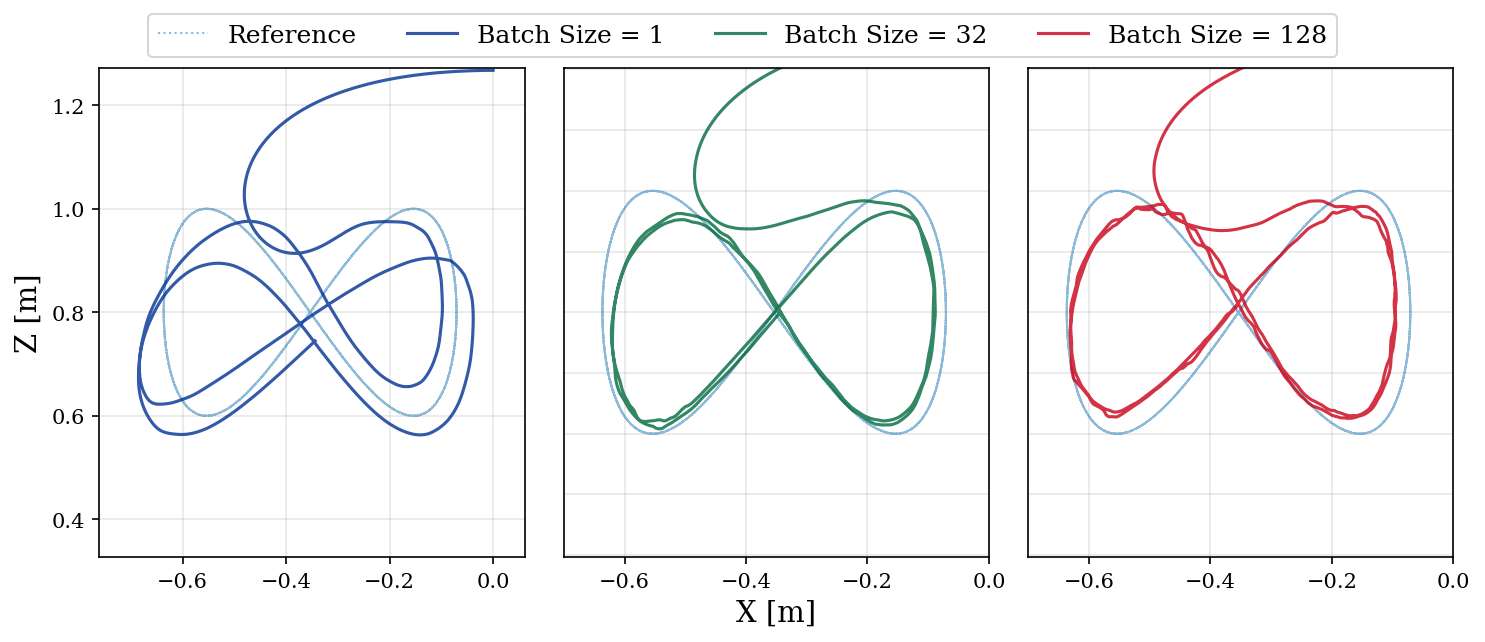

In [14]:
base_palette = { 
    '1':   '#003192',  # Barnard Blue
    '4':   '#747474',  # gray
    '8':  '#7030A0',   # purple
    '16':   '#F19759', # orange
    '32':  '#00693E',  # Dartmouth Green
    '64':  '#56B4E9',  # sky blue (distinct from dark blue)
    '128': '#C90016',  # Harvard Crimson
}

# Single vs Batch=32 vs Batch=128 XZ Projection Comparison (side by side)
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Left plot: Single Solver
ax = axes[0]
ax.plot(ref_traj[:, 0], ref_traj[:, 2], ':', linewidth=1.0, label='Reference', alpha=0.5)
if 'ee_actual' in mpc_stats and len(mpc_stats['ee_actual']) > 0:
    ee_single = mpc_stats['ee_actual']
    ax.plot(ee_single[:, 0], ee_single[:, 2], color=base_palette['1'], linewidth=1.5, label='Batch Size = 1', alpha=0.8)
# ax.set_xlabel('X [m]')
ax.set_ylabel('Z [m]', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axis('equal')
ax.set_xlim(-0.7, 0.0)
ax.set_ylim(0.5, 1.1)

# Middle plot: Batch=32
ax = axes[1]
ax.plot(ref_traj[:, 0], ref_traj[:, 2], ':', linewidth=1.0, alpha=0.5)
if 'ee_actual' in mpc_stats_32 and len(mpc_stats_32['ee_actual']) > 0:
    ee_batch32 = mpc_stats_32['ee_actual']
    ax.plot(ee_batch32[:, 0], ee_batch32[:, 2], color=base_palette['32'], linewidth=1.5, label='Batch Size = 32', alpha=0.8)
ax.set_xlabel('X [m]', fontsize=14)
# ax.set_ylabel('Z [m]')
ax.grid(True, alpha=0.3)
# Remove y-axis tick marks but keep gridlines
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.axis('equal')
ax.set_xlim(-0.7, 0.0)
ax.set_ylim(0.5, 1.1)

# Right plot: Batch=128
ax = axes[2]
ax.plot(ref_traj[:, 0], ref_traj[:, 2], ':', linewidth=1.0, alpha=0.5)
if 'ee_actual' in mpc_stats_128 and len(mpc_stats_128['ee_actual']) > 0:
    ee_batch128 = mpc_stats_128['ee_actual']
    ax.plot(ee_batch128[:, 0], ee_batch128[:, 2], color=base_palette['128'], linewidth=1.5, label='Batch Size = 128', alpha=0.8)
# ax.set_xlabel('X [m]')
# ax.set_ylabel('Z [m]')
ax.grid(True, alpha=0.3)
# Remove y-axis tick marks but keep gridlines
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.axis('equal')
ax.set_xlim(-0.7, 0.0)
ax.set_ylim(0.5, 1.1)

# Add single legend for all subplots
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while preserving order
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

fig.legend(unique_handles, unique_labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4)

plt.tight_layout()
plt.subplots_adjust(top=0.97)
plt.savefig('fig8-disturbance.png', bbox_inches='tight')
plt.show()

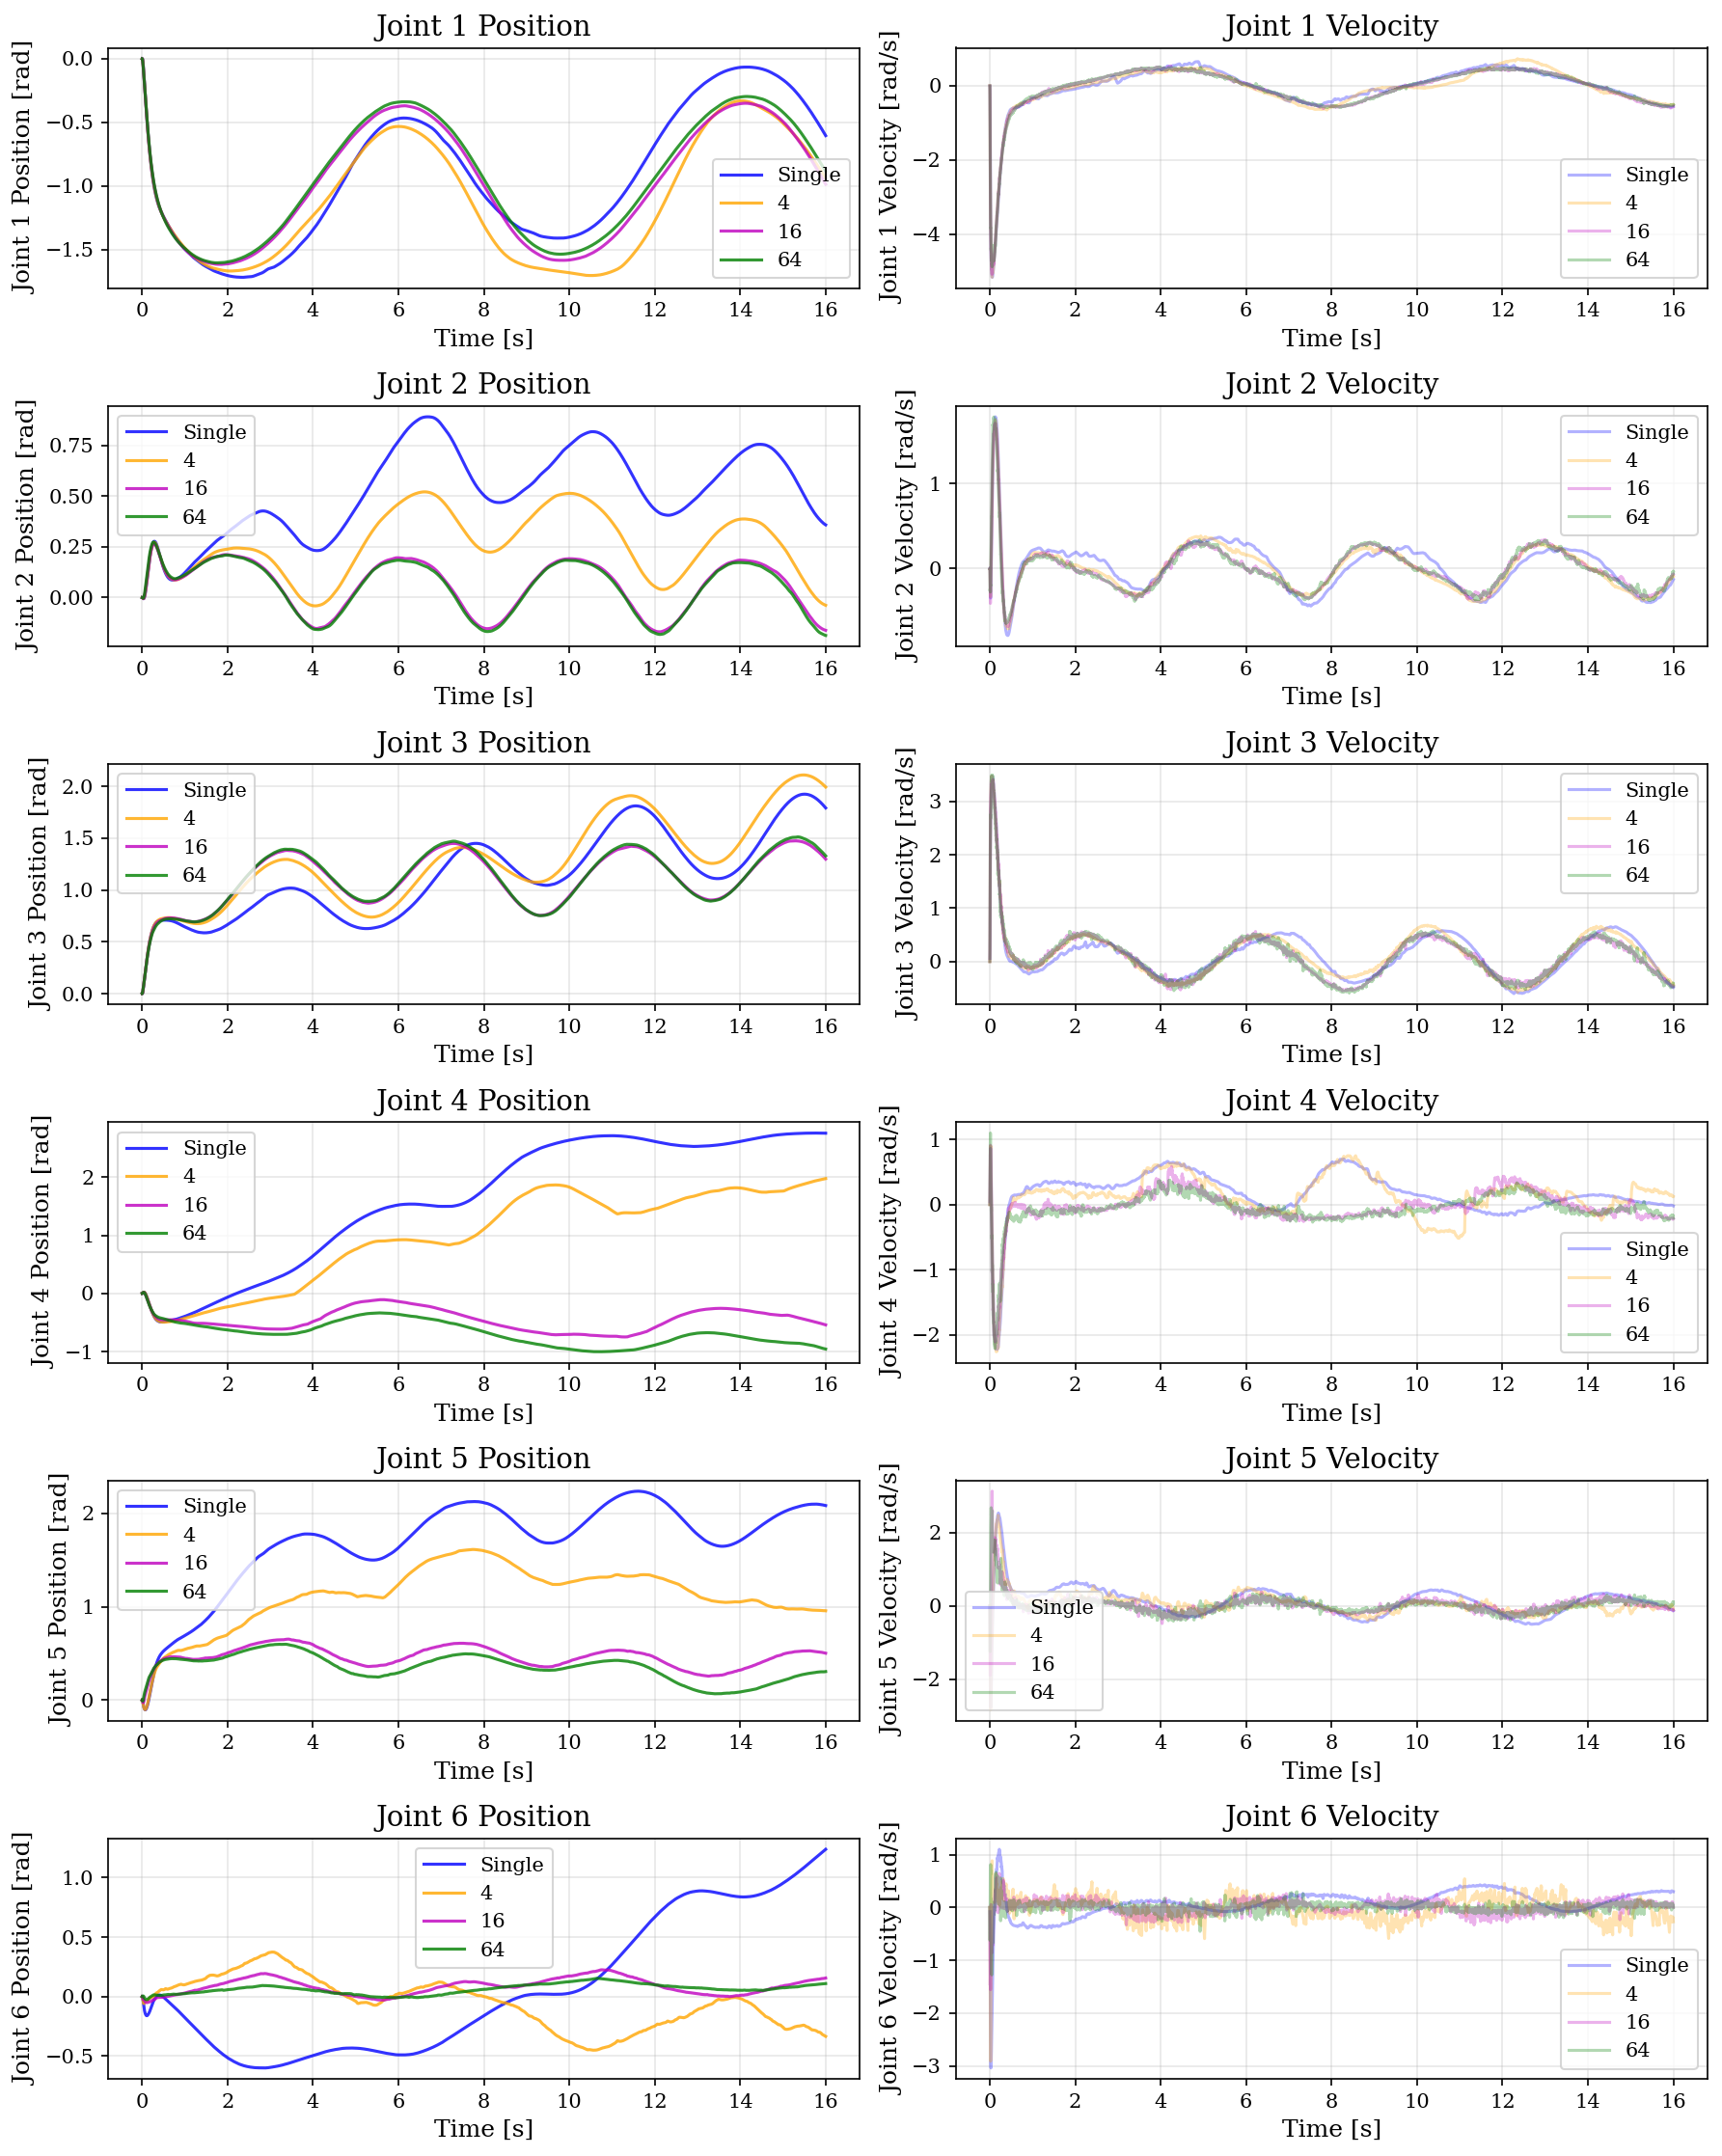

In [16]:
# Joint-Level Analysis
fig, axes = plt.subplots(6, 2, figsize=(12, 15))

joints_to_plot = [0, 1, 2, 3, 4, 5] 

for idx, joint_idx in enumerate(joints_to_plot):
    # Joint positions
    ax = axes[idx, 0]
    if 'joint_positions' in mpc_stats and len(mpc_stats['joint_positions']) > 0:
        ax.plot(mpc_stats['timestamps'], mpc_stats['joint_positions'][:, joint_idx], 
                'b-', linewidth=1.5, label='Single', alpha=0.8)
    if 'joint_positions' in mpc_stats_4 and len(mpc_stats_4['joint_positions']) > 0:
        ax.plot(mpc_stats_4['timestamps'], mpc_stats_4['joint_positions'][:, joint_idx], 
                'orange', linewidth=1.5, label='4', alpha=0.8) 
#     if 'joint_positions' in mpc_stats_8 and len(mpc_stats_8['joint_positions']) > 0:
#         ax.plot(mpc_stats_8['timestamps'], mpc_stats_8['joint_positions'][:, joint_idx], 
#                 'y-', linewidth=1.5, label='8', alpha=0.8) 
    if 'joint_positions' in mpc_stats_16 and len(mpc_stats_16['joint_positions']) > 0:
        ax.plot(mpc_stats_16['timestamps'], mpc_stats_16['joint_positions'][:, joint_idx], 
                'm-', linewidth=1.5, label='16', alpha=0.8) 
#     if 'joint_positions' in mpc_stats_32 and len(mpc_stats_32['joint_positions']) > 0:
#         ax.plot(mpc_stats_32['timestamps'], mpc_stats_32['joint_positions'][:, joint_idx], 
#                 'm-', linewidth=1.5, label='32', alpha=0.8) 
    if 'joint_positions' in mpc_stats_64 and len(mpc_stats_64['joint_positions']) > 0:
        ax.plot(mpc_stats_64['timestamps'], mpc_stats_64['joint_positions'][:, joint_idx], 
                'g-', linewidth=1.5, label='64', alpha=0.8)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(f'Joint {joint_idx+1} Position [rad]')
    ax.set_title(f'Joint {joint_idx+1} Position')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Joint velocities
    ax = axes[idx, 1]
    if 'joint_velocities' in mpc_stats and len(mpc_stats['joint_velocities']) > 0:
        ax.plot(mpc_stats['timestamps'], mpc_stats['joint_velocities'][:, joint_idx], 
                'b-', linewidth=1.5, label='Single', alpha=0.3)
    if 'joint_velocities' in mpc_stats_4 and len(mpc_stats_4['joint_velocities']) > 0:
        ax.plot(mpc_stats_4['timestamps'], mpc_stats_4['joint_velocities'][:, joint_idx], 
                'orange', linewidth=1.5, label='4', alpha=0.3) 
#     if 'joint_velocities' in mpc_stats_8 and len(mpc_stats_8['joint_velocities']) > 0:
#         ax.plot(mpc_stats_8['timestamps'], mpc_stats_8['joint_velocities'][:, joint_idx], 
#                 'y-', linewidth=1.5, label='8', alpha=0.8) 
    if 'joint_velocities' in mpc_stats_16 and len(mpc_stats_16['joint_velocities']) > 0:
        ax.plot(mpc_stats_16['timestamps'], mpc_stats_16['joint_velocities'][:, joint_idx], 
                'm-', linewidth=1.5, label='16', alpha=0.3) 
#     if 'joint_velocities' in mpc_stats_32 and len(mpc_stats_32['joint_velocities']) > 0:
#         ax.plot(mpc_stats_32['timestamps'], mpc_stats_32['joint_velocities'][:, joint_idx], 
#                 'm-', linewidth=1.5, label='32', alpha=0.8) 
    if 'joint_velocities' in mpc_stats_64 and len(mpc_stats_64['joint_velocities']) > 0:
        ax.plot(mpc_stats_64['timestamps'], mpc_stats_64['joint_velocities'][:, joint_idx], 
                'g-', linewidth=1.5, label='64', alpha=0.3)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(f'Joint {joint_idx+1} Velocity [rad/s]')
    ax.set_title(f'Joint {joint_idx+1} Velocity')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('joint_analysis.pdf', bbox_inches='tight')
plt.show()